# Simple data

In [101]:
import bpy
from IPython.display import display, Image

def fresh_scene(keep_cube=False):
    # Deselect all objects
    bpy.ops.object.select_all(action='DESELECT')
    
    # Select all objects except cameras and optionally the default cube
    for obj in bpy.context.scene.objects:
        if obj.type == 'CAMERA':
            obj.select_set(False)
        elif obj.name == 'Cube' and keep_cube:
            obj.select_set(False)
        else:
            obj.select_set(True)
    
    bpy.ops.object.delete()
    
    # Add light
    bpy.ops.object.light_add(type='SUN')
    sun = bpy.context.object

    sun.location = (0, 0, 0)
    from math import radians
    sun.rotation_euler = (radians(204), radians(-133), radians(-67))
    sun.data.energy = 5  

def render_result():
    bpy.ops.render.render()
    bpy.data.images['Render Result'].save_render(filepath="img.png")
    display(Image(filename="img.png"))

bpy.context.scene.render.resolution_x = 500
bpy.context.scene.render.resolution_y = 200

In [107]:
import bpy
import subprocess
import sys

# Path to Blender's Python executable
python_executable = sys.executable
try:
    subprocess.check_call([python_executable, "-m", "pip", "install", "polars"])
    subprocess.check_call([python_executable, "-m", "pip", "install", "matplotlib"])

    print("Done")
except Exception as e:
    print(f"An error occurred: {e}")


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: /Applications/Blender.app/Contents/Resources/4.3/python/bin/python3.11 -m pip install --upgrade pip


Done



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: /Applications/Blender.app/Contents/Resources/4.3/python/bin/python3.11 -m pip install --upgrade pip


In [108]:
import polars as pl
url = 'https://raw.githubusercontent.com/kolibril13/ipydrop/refs/heads/main/dino.csv'
df = pl.read_csv(url)
length_data = len(df)
print(f"Loaded {length_data} rows")
df.head()

Loaded 142 rows


x,y
f64,f64
55.3846,97.1795
51.5385,96.0256
46.1538,94.4872
42.8205,91.4103
40.7692,88.3333


In [109]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

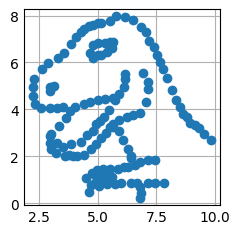

In [110]:
# Extract x and y from the DataFrame
x_values = df['x'] / 10 
y_values = df['y'] / 10 * 0.8

# Create the scatter plot using plt.scatter
plt.axis('equal');
plt.scatter(x_values, y_values);

In [112]:
def camera_from_above():
    camera = bpy.context.scene.camera
    camera.location = (6, 4, 10)  # Position above the XY plane
    camera.rotation_euler = (0, 0, 0)  # Rotate to look at XY plane
    # Set the camera to orthographic mode
    camera.data.type = 'ORTHO'
    # Set the orthographic scale to 12
    camera.data.ortho_scale = 9

    bpy.context.scene.render.resolution_x = 300
    bpy.context.scene.render.resolution_y = 300

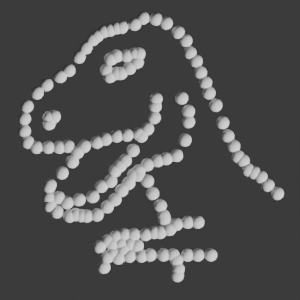

In [113]:
fresh_scene()

for (x, y) in zip(x_values,y_values):    
    bpy.ops.mesh.primitive_uv_sphere_add(radius=0.2, location=(x, y, 0))

camera_from_above()
render_result()

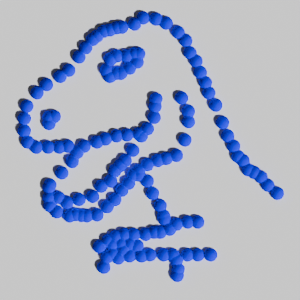

[I 2025-01-13 17:56:52.905 ServerApp] Saving file at /docs/n2data_simple.ipynb
[W 2025-01-13 17:56:52.905 ServerApp] Notebook docs/n2data_simple.ipynb is not trusted
[I 2025-01-13 17:56:54.891 ServerApp] Saving file at /docs/n2data_simple.ipynb
[W 2025-01-13 17:56:54.894 ServerApp] Notebook docs/n2data_simple.ipynb is not trusted


In [114]:
fresh_scene()

mat = bpy.data.materials.new(name="GreenMaterial")
mat.diffuse_color = (0, 0, 1, 1)  # Green color (R, G, B, A)

for (x, y) in zip(x_values,y_values):    
    bpy.ops.mesh.primitive_uv_sphere_add(radius=0.2, location=(x, y, 0))
    bpy.context.active_object.data.materials.append(mat)

bpy.context.scene.render.resolution_x = 300
bpy.context.scene.render.resolution_y = 300

# Add a white plane behind the spheres
bpy.ops.mesh.primitive_plane_add(size=20, location=(5, 5, 0))  
plane = bpy.context.active_object

# Create a white material and assign it to the plane
white_mat = bpy.data.materials.new(name="WhiteMaterial")
white_mat.diffuse_color = (1, 1, 1, 1)  # White color (R, G, B, A)
plane.data.materials.append(white_mat)

render_result()

this works, but it's very limited!
E.g. 
* not possible to scale individual spheres.
* not possible to use geometry nodes with this object.



Can we maybe add this geometry nodes setup?

# Loading Pre-Defined Geometry Nodes
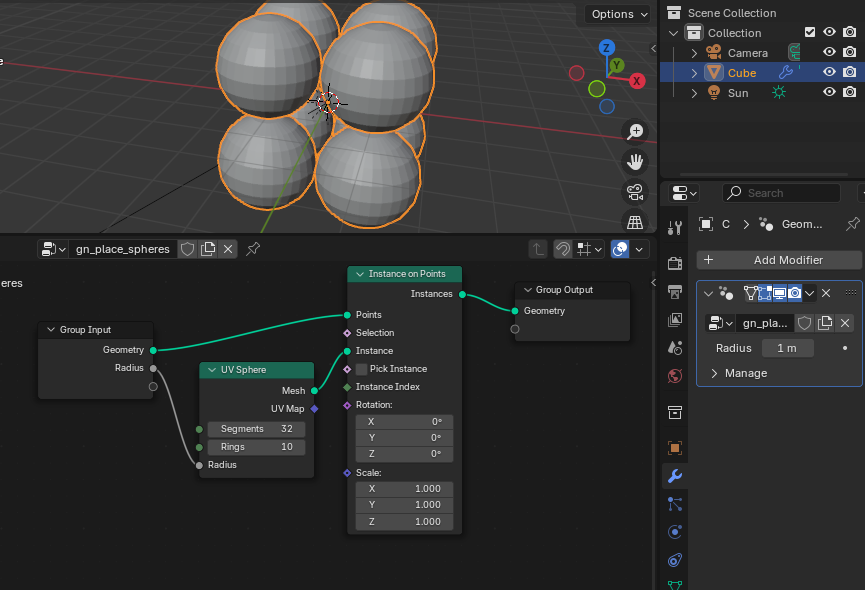

In [117]:
# option 1: Load the node group to the current blend scene
#TODO Make this it's own utility tool
import bpy
# Path to the blend file
blend_file_path = "docs/cube_gn_position.blend"
node_group_name = "gn_place_spheres"

# Load only the node group from the blend file
with bpy.data.libraries.load(blend_file_path, link=False) as (data_from, data_to):
    if node_group_name in data_from.node_groups:
        data_to.node_groups = [node_group_name]

# Access the node group
node_group_place_spheres = bpy.data.node_groups[node_group_name]

# Print all the node names inside the node group
print(f"Nodes in node group '{node_group_name}':")
for node in node_group_place_spheres.nodes:
    print(node.name)

Nodes in node group 'gn_place_spheres':
Group Input
Group Output
Instance on Points
UV Sphere


In [118]:
# option 2: Open the compeletely new blend file and access the node group
#bpy.ops.wm.open_mainfile(filepath="cube_gn_position.blend")

# Access the node group
#node_group_place_spheres = bpy.data.node_groups["gn_place_spheres"]

# Print all the node names inside the node group
#print("Nodes in node group 'gn_place_spheres':")
#for node in node_group_place_spheres.nodes:
#    print(node.name)

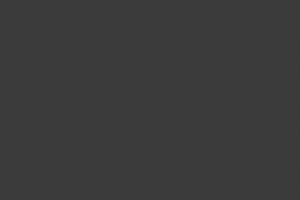

In [119]:
fresh_scene()
import mathutils

# Create a new mesh and object for the point cloud
mesh = bpy.data.meshes.new("HelloMesh")
my_point_obj = bpy.data.objects.new("HelloPoint", mesh)
points = [mathutils.Vector((6, 4, 0))]  # One point at coordinates
# Apply the points to the mesh
mesh.from_pydata(vertices = points, edges=[], faces=[])
mesh.update()
bpy.context.collection.objects.link(my_point_obj)


bpy.context.scene.render.resolution_x = 300
bpy.context.scene.render.resolution_y = 200
render_result()

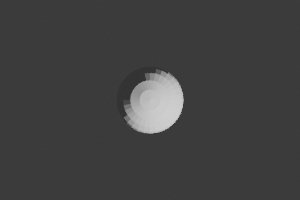

In [120]:
modifier = my_point_obj.modifiers.new(name="GeometryNodes", type='NODES')
modifier.node_group = node_group_place_spheres
render_result()

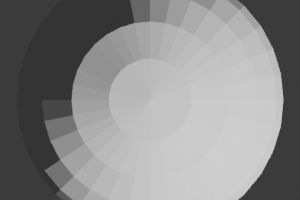

In [121]:
my_point_obj.modifiers["GeometryNodes"]["Socket_2"] = 4 # set radius
render_result()

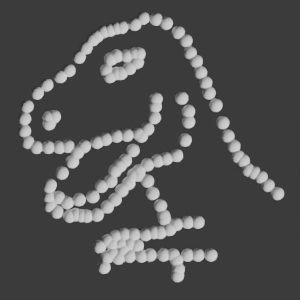

In [122]:
fresh_scene()

# Create a new mesh and object for the point cloud
mesh = bpy.data.meshes.new("HelloDenoMesh")
my_point_obj = bpy.data.objects.new("HelloDeno", mesh)

points = [mathutils.Vector((x, y, 0)) for x, y in zip(x_values, y_values)]  # Create points from DataFrame

# Apply the points to the mesh
mesh.from_pydata(vertices=points, edges=[], faces=[])
mesh.update()
bpy.context.collection.objects.link(my_point_obj)


modifier = my_point_obj.modifiers.new(name="GeometryNodes", type='NODES')
modifier.node_group = node_group_place_spheres

my_point_obj.modifiers["GeometryNodes"]["Socket_2"] = 0.2  # Set radius

camera_from_above()
render_result()

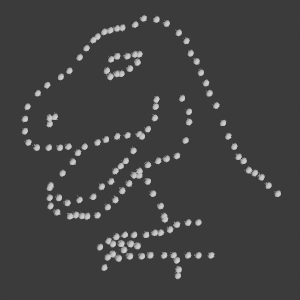

In [123]:
my_point_obj.modifiers["GeometryNodes"]["Socket_2"] = 0.1  # Set radius

render_result()

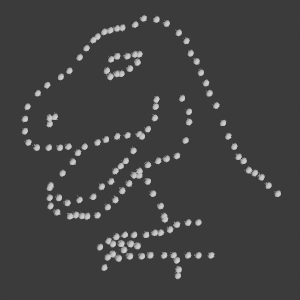

In [124]:
# 💡 Now we can squeeze or change anything in geonodes!
render_result()

In [125]:
# Also possible to change the data points
import pandas as pd
url = 'https://raw.githubusercontent.com/kolibril13/ipydrop/refs/heads/main/star.csv'
df = pd.read_csv(url)
df.head()

,x,y
0,58.213608,91.881892
1,58.196054,92.214989
2,58.718231,90.310532
3,57.278373,89.907607
4,58.082020,92.008145


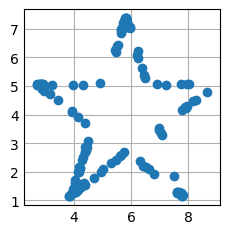

In [126]:
x_values = df['x'] / 10 
y_values = df['y'] / 10 * 0.8

plt.axis('equal');
plt.scatter(x_values, y_values);

In [127]:
# Only update the vertex positions without clearing the geometry
for i, (x, y) in enumerate(zip(x_values, y_values)):
    my_point_obj.data.vertices[i].co = (x, y, 0)

# Update the mesh and force Blender to recalculate
my_point_obj.data.update()
bpy.context.view_layer.update()

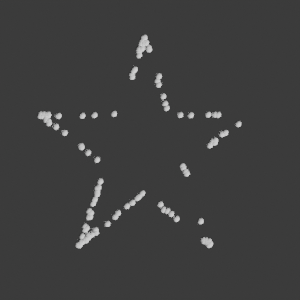

[I 2025-01-13 17:58:30.954 ServerApp] Saving file at /docs/n2data_simple.ipynb


In [128]:
render_result()